# Time Serie Resampling

## Introduction

When dealing with Time Series we are often facing different Time Conventions and AveragingMethodology. This notebook provides useful insight to answer:

> &laquo;&nbsp;How can we correlate Time Series computed from Sample?&nbsp;&raquo;

In this notebook we show capabilities of Pandas in dealing with this issue and how to handle it properly.
Also see [Time Serie Synchronization][1].

[1]: ./TimeSerieSynchronization.ipynb

## Imports

Only `pandas` is required in this notebook, `matplotlib` and `numpy` are invoked for convenience only.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = 0.75*np.array(mpl.rcParams['figure.figsize'])
import pandas as pd

In [2]:
import random
seed = 28
random.seed(seed)
np.random.seed(seed)

## Methdology

We need to compare Time Series from several datasets with different granularities to asses:

 - Synchronization: Do Timestamps in series remain correct through the datafrlow?
 - Averaging Methodology: Does Averaging Methodology change?
 
For this purpose, we will define an objective criterion.

### Shifted Relative Error Test

First we define a dimensionless quantity $r$ we call *Shifted Relative Error* to compare records among datasets. We define this quantity as follow:

$$r_{s,\lambda}(t) = \frac{x_{s,\mathrm{exp}}(t + \lambda \Delta t_x) - x_{s,\mathrm{ref}}(t)}{x_{s,\mathrm{ref}}(t)}
 \quad \forall s \in S, \, \forall t \in [t_\min,t_\max], \, \lambda \in \mathbb{Z}$$

Where:

 - $s$ is the measurement site in the universe of sites $S$;
 - $t$ is the time over the considered period $[t_\min,t_\max]$;
 - $x_s(t)$ is the value of the averaged observable for some site $s$ at the time $t$;
 - $\lambda$ is the average shift index;
 - $\Delta t_x$ is the averaging period (or granularity) of the observable.
 - Indice `ref` stands for the reference dataset;
 - Indice `exp` stands for the trial dataset.

This methodology is suitable to anwser both of above questions. Notice than *Shifted Relative Error* as we haved defined it, exhibits some intersting properties:

 - Finding a $\lambda \neq 0$ that makes $\left|r_{s,\lambda}\right| \to 0, \,\forall t,\, \forall s$ over a defined period does not prove but will strongly suggest the existence of a time shift;
 - If a time shift exists without change of averaging methodology, it must be identified in both side of the **critical time** (Timestamp when time shift occurs) with two consecutive value of $\lambda$ and $\lambda + 1$;

### Shifted Sampling Relative Error

We slightly modify the definition above to detect a shift of averaging window instead of an average shift, the quantity becomes:


$$r_{s,\gamma}(t) = \frac{\frac{1}{n} \sum\limits_{i=\gamma}^{\gamma + n} z_{s,\mathrm{exp}}(t + i \Delta t_z) - x_{s,\mathrm{ref}}(t)}{x_{s,\mathrm{ref}}(t)} \quad \Delta t_x = n \Delta t_x,\, n \in \mathbb{N}_0, \gamma \in \mathbb{Z}$$


Where:

 - $\gamma$ is the sample shift index;
 - $z_s(t)$ is the value of the observable (sample used for average);
 - $\Delta t_z$ is the sampling period (or granularity) of the sample value, we only consider equally spaced sample;
 - $n$ is the number of sample in the averaging period.

The latter definition is a generalization of the former. When $\gamma = n \lambda$, both formula are equal. Observations made on the first definition can be extended to:

 - Finding a $\gamma \neq 0$ that makes $\left|r_{s,\gamma}\right| \to 0, \,\forall t,\, \forall s$ over a defined period does not prove but will strongly suggest the existence of a time shift;
 - Average shift from either side should occur for $\lambda$ and $\lambda + n$, corrolary is $\gamma = n \lambda$ must hold;
 - If $\gamma = n \lambda$ does not hold, then windows are not synchronized across the Critical Time.

### Implementation

Both definitions above have been implemented in a single function using shifting and resampling methods.
It is available in the AirPy project in package `airpy.scientific.compare` as `shiftedRelativeError` method.

Below the current code of the function:

In [3]:
from airpy.scientific import compare

## Trial datasets

### Raw Records

We create a trial DataFrame with random numbers with 10 channels during a month sampled with 5 minutes period.
Data are stored using the closed to the right convention:

In [4]:
nC = 5
t0 = pd.date_range(start='2010-01-01 00:00:00', end='2010-02-01 00:00:00', freq='5T', closed='right')
x0 = np.random.randn(t0.size, nC)
raw = pd.DataFrame(x0, index=t0)
raw.iloc[:5,:]

,0,1,2,3,4
2010-01-01 00:05:00,0.446332,1.669120,-0.264280,-0.967835,0.059188
2010-01-01 00:10:00,1.514620,0.336870,-0.302369,-0.838642,-0.517731
2010-01-01 00:15:00,0.253508,-2.484704,-0.651420,-1.775469,0.234286
2010-01-01 00:20:00,1.239400,-0.650334,-0.266215,-0.538720,0.420741
2010-01-01 00:25:00,-0.095286,-0.769876,-0.183725,0.176809,0.737056


Now, we will create half hourly means for all channels with the requirement to keep time convention.

### Aggregated Records

#### Synchronized Mean
We create an aggregated 30 minutes mean with same time convention:

In [5]:
agg0 = raw.resample('30T', closed='right', label='right').mean()
agg0.iloc[:5,:]

,0,1,2,3,4
2010-01-01 00:30:00,0.675406,-0.452409,-0.213388,-0.639553,0.103160
2010-01-01 01:00:00,-0.142859,-0.043982,0.247526,0.369549,0.158189
2010-01-01 01:30:00,0.534679,-0.567000,-0.652909,-0.246096,0.138693
2010-01-01 02:00:00,0.441195,0.047251,-0.196375,-0.527124,0.541175
2010-01-01 02:30:00,-0.000140,0.345938,-0.525335,0.542621,0.198279


#### Shifted Average

In [6]:
agg1 = raw.resample('30T', closed='right', label='right').mean().shift(-2)
agg1.iloc[-5:,:]

,0,1,2,3,4
2010-01-31 22:00:00,0.475626,-0.036286,0.563465,0.203187,0.817863
2010-01-31 22:30:00,-0.143553,-0.306606,1.005748,0.562050,0.184797
2010-01-31 23:00:00,0.845937,-0.640141,0.621105,-0.622346,-0.044123
2010-01-31 23:30:00,NaN,NaN,NaN,NaN,NaN
2010-02-01 00:00:00,NaN,NaN,NaN,NaN,NaN


#### Shifted Averaging Window

And a shifted records average:

In [7]:
agg2 = raw.shift(-2).resample('30T', closed='right', label='right').mean()
agg2.iloc[:5,:]

,0,1,2,3,4
2010-01-01 00:30:00,0.390673,-0.878319,0.113646,-0.095822,0.045996
2010-01-01 01:00:00,-0.037140,0.081848,-0.159529,0.325786,0.381592
2010-01-01 01:30:00,0.751006,-0.386310,-0.652545,-0.815657,0.098360
2010-01-01 02:00:00,0.164105,0.103048,-0.008424,0.024587,0.420831
2010-01-01 02:30:00,-0.228739,0.804657,-0.468524,0.462305,0.375905


#### Shifted Averaging Window with corrupted means 

In [8]:
mask = np.random.choice(np.arange(10)<1, size=agg2.shape)
agg3 = agg2.mask(mask, 0.05)
agg3.iloc[:5,:]

,0,1,2,3,4
2010-01-01 00:30:00,0.390673,-0.878319,0.113646,-0.095822,0.045996
2010-01-01 01:00:00,-0.037140,0.081848,-0.159529,0.325786,0.381592
2010-01-01 01:30:00,0.751006,-0.386310,-0.652545,-0.815657,0.098360
2010-01-01 02:00:00,0.164105,0.103048,-0.008424,0.024587,0.420831
2010-01-01 02:30:00,-0.228739,0.804657,-0.468524,0.462305,0.375905


## Results & Discussion

First we define a shortcut for our settings (series closed to the right, mean is the aggregate, return full checks):

In [9]:
shifter = lambda x, y, k: compare.shiftedRelativeError(x, y, shift=k, closed='right', label='right', agg='mean', mode='all', checks=True)

### Identity

First we will check that comparing the same dataset with function returns the correct result:

In [10]:
res = shifter(raw, raw, 0)

We see $\left|r_{s,\lambda}\right| \leq \epsilon$

In [11]:
res['checks']['allnull']

True

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcdcc6be5c0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fcdcc571cc0>], dtype=object)

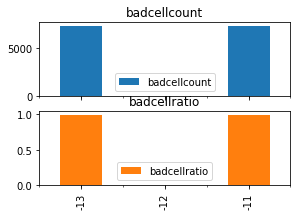

In [20]:
extent = np.arange(-13, -10)
stats = compare.exploreShifts(raw, agg1, extent, plot=False, ylim=[-5, 5], xmarkers=[])
stats['synthesis'].plot(kind='bar', subplots=True)

[0.98869448183041719, 0.0, 0.98964357767316746]


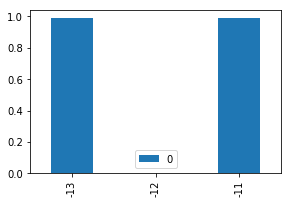

In [13]:
x = [stats[k]['checks']['badcellratio'] for k in extent]
print(x)
error = pd.DataFrame(x, index=extent)
error.plot(kind="bar")

In [14]:
#_ = exploreShifts(raw, agg0, np.arange(-1, 2), plot=True, ylim=[-5, 5], xmarkers=[])

In [15]:
#_ = exploreShifts(raw, agg2, np.arange(-3, 0), plot=True, ylim=[-5, 5], xmarkers=[])

In [16]:
#_ = exploreShifts(raw, agg2, np.arange(-3, 0), plot=True, ylim=[-5, 5], xmarkers=[])

In [17]:
#_ = exploreShifts(raw, agg3, np.arange(-3, 0), plot=True, ylim=[-5, 5], xmarkers=[])